In [87]:
from sortedcontainers import SortedList

In [2]:
import pandas as pd
import networkx as nx

In [49]:
filled = pd.read_csv('filled.csv').iloc[:, 1:]
features = pd.read_csv('features.csv').iloc[:, 1:]

In [50]:
corr_mat = features.corr('spearman')
top_vals = corr_mat > 0.75

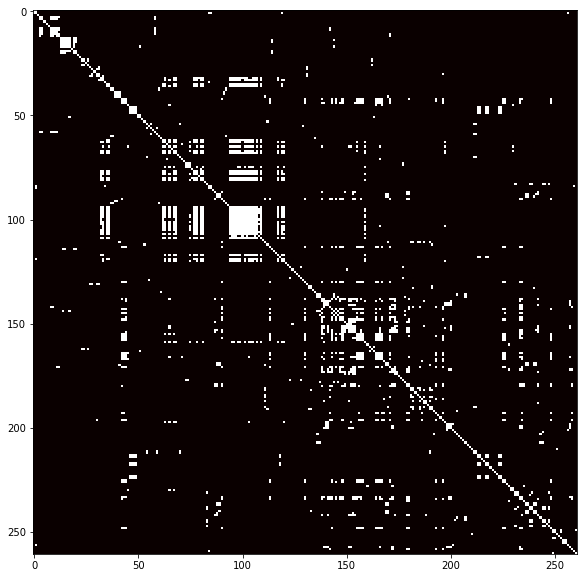

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(top_vals, cmap='hot', interpolation='none')

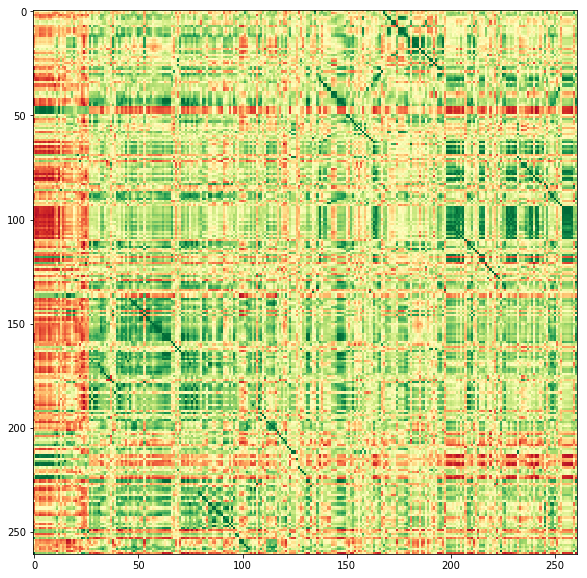

In [52]:
import numpy as np
import scipy
import scipy.cluster.hierarchy as sch

X = features.corr().values
d = sch.distance.pdist(X) 
L = sch.linkage(d, method='average')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [features.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = features.corr().reindex(columns, axis=1)

plt.figure(figsize=(10, 10))
plt.imshow(df, cmap='RdYlGn', interpolation='none')

In [53]:
import networkx as nx

In [131]:
g = nx.Graph(corr_mat > 0.75)

In [132]:
cliqs = []

for idx, cliq in enumerate(nx.find_cliques(g)):
    if idx > 1000:
        break
    cliqs.append(cliq)

In [104]:
query = [filled.loc[filled.peakIndex == int(vtx), :].peakPPM.mean() for vtx in cliks[0]]

In [133]:
class Peak:
    def __init__(self, metabolite_id, ppm, amp):
        self.metabolite_id = metabolite_id
        self.ppm = ppm
        self.amp = amp
    
    def __eq__(self, other):
        return self.ppm == other.ppm
    
    def __lt__(self, other):
        return self.ppm < other.ppm
    
    def __str__(self):
        return f'<Peak metabolite_id:{self.metabolite_id} ppm:{self.ppm} amplitude:{self.amp}>'

In [134]:
import glob

peaks = []
peak_sizes = {}
for met_idx, d in enumerate(glob.glob('../data/metabolites/bmse*')):
    metabolite_id = d.split('/')[-1] 
    peak_df = pd.read_csv(f'{d}/simulation_1/peaks/sim_600MHz_peaks_standard.csv')
    
    for idx, peak in peak_df.iterrows():
        peaks.append(Peak(metabolite_id, peak['PPM'], peak['Amp']))
        
    peak_sizes[metabolite_id] = len(peak_df)

peak_db = SortedList(peaks)
print(f'found {len(peaks)} peaks across {met_idx+1} metabolites')

found 233 peaks across 17 metabolites


In [140]:
def query_db(query, peak_db, peak_sizes, tolerance=0.02):
    result_map = {}
    for q in query:
        matched = set()
        lower = Peak(None, q - tolerance, None)
        upper = Peak(None, q + tolerance, None)

        for retrieved_peak in peak_db.irange(lower, upper):
            if retrieved_peak.metabolite_id not in result_map:
                result_map[retrieved_peak.metabolite_id] = 0
                    
            if retrieved_peak.metabolite_id not in matched:
                matched.add(retrieved_peak.metabolite_id)
                result_map[retrieved_peak.metabolite_id] += 1
    
    metabolite_list = []
    for met_id, overlap in result_map.items():
        jaccard_score = overlap / (peak_sizes[met_id] + len(query) - overlap)
        metabolite_list.append((met_id, jaccard_score, overlap))
    
    return sorted(metabolite_list, key=lambda i: i[1], reverse=True)

In [136]:
query_db(query, peak_db, peak_sizes)

[('bmse000176', 0.045454545454545456), ('bmse000005', 0.027777777777777776)]

In [143]:
# query cliques
for idx, cliq in enumerate(cliqs):
    query = [filled.loc[filled.peakIndex == int(vtx), :].peakPPM.mean() for vtx in cliq]
    res = query_db(query, peak_db, peak_sizes)
    print(idx, res)
    
    break

0 [('bmse000176', 0.045454545454545456, 1), ('bmse000005', 0.027777777777777776, 1)]


In [160]:
# associate cliques to samples
for peak in cliqs[170]:
    print(set(filled.loc[filled.peakIndex == int(peak), :].Sample))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
